
<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/mlab/w1d4_part1_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Only execute on Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !git clone --depth 1 https://github.com/EffiSciencesResearch/ML4G.git
    !cd ML4G
    !pip install -r /content/ML4G/requirements.txt --quiet
    %cd /content/ML4G/mlab

Cloning into 'ML4G'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (373/373), done.
remote: Compressing objects: 100% (328/328), done.
remote: Total 373 (delta 54), reused 261 (delta 36), pack-reused 0
Receiving objects: 100% (373/373), 386.13 MiB | 18.93 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Updating files: 100% (388/388), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.5 MB/s eta 0:00:00
  Preparing met


# W1D4 Part 1 - Optimization

Today's material is divided into two parts. In the first part, you're going to learn more about the training loop and different optimizers. In the second part, you'll practice experimenting with different hyperparameters and learn how to do a distributed hyperparameter search.

By the end of the day, you'll have trained your ResNet from W1D2 using your own optimizer and hyperparameters!

## Table of Contents

- [Readings](#readings)
- [Gradient Descent](#gradient-descent)
- [Hyperparameters](#hyperparameters)
- [Stochastic Gradient Descent](#stochastic-gradient-descent)
- [Batch Size](#batch-size)
- [Computing Gradients in PyTorch - W1D3 Review](#computing-gradients-in-pytorch---wd-review)
  - [Stopping gradients with `torch.no_grad` or `torch.inference_mode`](#stopping-gradients-with-torchnograd-or-torchinferencemode)
- [Common Themes in Gradient-Based Optimizers](#common-themes-in-gradient-based-optimizers)
  - [Weight Decay](#weight-decay)
  - [Momentum](#momentum)
  - [Many More Optimizer Variants](#many-more-optimizer-variants)
- [Exercise: Learning To Reproduce a Picture](#exercise-learning-to-reproduce-a-picture)
  - [The "device" variable](#the-device-variable)
- [Build Your Own TensorDataset](#build-your-own-tensordataset)
  - [Slice Objects in Python](#slice-objects-in-python)
- [Data Preprocessing](#data-preprocessing)
  - [Train-Test Split](#train-test-split)
  - [Visualizing the Training Data](#visualizing-the-training-data)
- [DataLoaders](#dataloaders)
- [Visualising Optimization With Rosenbrock's Banana](#visualising-optimization-with-rosenbrocks-banana)
- [Build Your Own Optimizers](#build-your-own-optimizers)
  - [Gotcha: In-Place Operations](#gotcha-in-place-operations)
  - [More Tips](#more-tips)
  - [SGD](#sgd)
  - [RMSprop](#rmsprop)
  - [Adam](#adam)
- [Onward to Part 2](#onward-to-part-)
- [Bonus](#bonus)

## Readings

None for today!

## Gradient Descent

Yesterday, you implemented backpropagation. Today, we're going to use the gradients produced by backpropagation for optimizing a loss function using gradient descent.

A loss function can be any differentiable function such that we prefer a lower value. To apply gradient descent, we start by initializing the parameters to random values (the details of this are subtle), and then repeatedly compute the gradient of the loss with respect to the model parameters. It [can be proven](https://tutorial.math.lamar.edu/Classes/CalcIII/DirectionalDeriv.aspx) that for an infinitesimal step, moving in the direction of the gradient would increase the loss by the largest amount out of all possible directions.

We actually want to decrease the loss, so we subtract the gradient to go in the opposite direction. Taking infinitesimal steps is no good, so we pick some learning rate $\lambda$ (also called the step size) and scale our step by that amount to obtain the update rule for gradient descent:

$$ \theta_t \leftarrow \theta_{t-1} - \lambda \nabla L(\theta_{t-1}) $$

We know that an infinitesimal step will decrease the loss, but a finite step will only do so if the loss function is linear enough in the neighbourhood of the current parameters. If the loss function is too curved, we might actually increase our loss.

The biggest advantage of this algorithm is that for N bytes of parameters, you only need N additional bytes of memory to store the gradients, which are of the same shape as the parameters. GPU memory is very limited, so this is an extremely relevant consideration. The amount of computation needed is also minimal: one multiply and one add per parameter.

The biggest disadvantage is that we're completely ignoring the curvature of the loss function, not captured by the gradient consisting of partial derivatives. Intuitively, we can take a larger step if the loss function is flat in some direction or a smaller step if it is very curved. Generally, you could represent this by some matrix P that pre-multiplies the gradients to rescale them to account for the curvature. P is called a preconditioner, and gradient descent is equivalent to approximating P by an identity matrix, which is a very bad approximation.

Most competing optimizers can be interpreted as trying to do something more sensible for P, subject to the constraint that GPU memory is at a premium. In particular, constructing P explicitly is infeasible, since it's an $N \times N$ matrix and N can be hundreds of billions. One idea is to use a diagonal P, which only requires N additional memory. An example of a more sophisticated scheme is [Shampoo](https://arxiv.org/pdf/1802.09568.pdf).

<details>

<summary>Why is it called Shampoo?</summary>

You put shampoo on your hair before using conditioner, and this method is a pre-conditioner. :D

</details>

## Hyperparameters

The learning rate is an example of a **hyperparameter**, which will be described below. As a reminder, a regular parameter is an adjustable value with the special and extremely convenient property that we can differentiate the loss with respect to the parameter, allowing us to efficiently learn good values for the parameter using gradient descent. In other words, the process of training is a function that takes a dataset, a model architecture, and a random seed and outputs model parameters.

The learning rate, in contrast, cannot be determined by this scheme. As a hyperparameter, we need to introduce an outer loop that wraps the training loop to search for good learning rate values. This outer loop is called a hyperparameter search, and each iteration consists of testing different combinations of hyperparameters using a dataset of pairs of $(\text{hyperparameters}, \text{validation performance})$. Obtaining results for each iteration (a single pair) requires running the inner training loop.

Due to a fixed budget of ML researcher time and available compute, we are interested in a trade-off between the ML researcher time, the cost of running the search, and the cost of training the final model. Due to the vast search space and cost of obtaining data, we don't hope to find any sort of optimum but merely to improve upon our initial guesses enough to justify the cost.

In addition, a hyperparameter isn't necessarily a single continuous value like the learning rate. Discrete unordered choices such as padding type as well as discrete ordered choices such as the number of layers in the network or the width of each convolution are all common. You will also need to choose between functions for optimizers, nonlinearities, or learning rate scheduling, of which there are an infinite number of possibilities, requiring us to select a small subset to test.

More broadly, every design decision can be considered a hyperparameter, including how to preprocess the input data, the connectivity of different layers, the types of operations, etc. Papers such as [AmeobaNet](https://arxiv.org/pdf/1802.01548.pdf) demonstrated that it's possible to find architectures superior to human-designed ones.

In the second part of today's material, you will learn about various strategies for searching over hyperparameters.

## Stochastic Gradient Descent

The terms gradient descent and SGD are used loosely in deep learning. To be technical, there are three variations:

- Batch gradient descent - the loss function is the loss over the entire dataset. This requires too much computation unless the dataset is small, so it is rarely used in deep learning.
- Stochastic gradient descent - the loss function is the loss on a randomly selected example. Any particular loss may be completely in the wrong direction of the loss on the entire dataset, but in expectation it's in the right direction. This has some nice properties but doesn't parallelize well, so it is rarely used in deep learning.
- Mini-batch gradient descent - the loss function is the loss on a batch of examples of size `batch_size`. This is the standard in deep learning.

The class `torch.SGD` can be used for any of these by varying the number of examples passed in. We will be using only mini-batch gradient descent in this course.

## Batch Size

In addition to choosing a learning rate or learning rate schedule, we need to choose the batch size or batch size schedule as well. Intuitively, using a larger batch means that the estimate of the gradient is closer to that of the true gradient over the entire dataset, but this requires more compute. Each element of the batch can be computed in parallel so with sufficient compute, one can increase the batch size without increasing wall-clock time. For small-scale experiments, a good heuristic is thus "fill up all of your GPU memory".

At a larger scale, we would expect diminishing returns of increasing the batch size, but empirically it's worse than that - a batch size that is too large generalizes more poorly in many scenarios. The intuition that a closer approximation to the true gradient is always better is therefore incorrect. See [this paper](https://arxiv.org/pdf/1706.02677.pdf) for one discussion of this.

For a batch size schedule, most commonly you'll see batch sizes increase over the course of training. The intuition is that a rough estimate of the proper direction is good enough early in training, but later in training it's important to preserve our progress and not "bounce around" too much.

You will commonly see batch sizes that are a multiple of 32. One motivation for this is that when using CUDA, threads are grouped into "warps" of 32 threads which execute the same instructions in parallel. So a batch size of 64 would allow two warps to be fully utilized, whereas a size of 65 would require waiting for a third warp to finish. As batch sizes become larger, this wastage becomes less important.

Powers of two are also common - the idea here is that work can be recursively divided up among different GPUs or within a GPU. For example, a matrix multiplication can be expressed by recursively dividing each matrix into four equal blocks and performing eight smaller matrix multiplications between the blocks.

Finally, there are considerations around the alignment of data in memory and "coalesced" accesses to that data. If this sort of thing sounds fun to you, make sure to attend GPU day on W1D6. :)

## Computing Gradients in PyTorch - W1D3 Review

Recall from W1D3 that gradients are only saved for `Tensor`s for which `requires_grad=True`. For convenience, `nn.Parameter` automatically sets `requires_grad=True` on the wrapped `Tensor`. As you call `torch` functions, PyTorch tracks the relevant information needed in case you call `backward` later on, at which point it does the actual computation to compute the gradient and stores it in the `Tensor`'s `grad` field.

Also recall that PyTorch accumulates gradients across multiple `backward` calls. So if your tensor's `grad` already contains a value, after calling `backward` again it will have the sum of the original value and the new gradient. This behavior comes in handy in many situations, such as computing gradients over multiple runs on a GPU as part of a single batch. Suppose you choose a batch size of 32, but only 8 inputs fit on your GPU. A typical loss function for a batch computes the sum of losses over each example, so you can compute the losses 8 at a time and sum their gradients, producing the same result as running all 32 inputs at once.

### Stopping gradients with `torch.no_grad` or `torch.inference_mode`

You may not want PyTorch to track gradients for some computations despite involving tensors with `requires_grad=True`. In this case, you can wrap the computation in the `with torch.inference_mode()` context to prevent this tracking. Example:


In [2]:
from typing import Iterable, Union, Optional, List, Tuple
import matplotlib.pyplot as plt
import matplotlib.figure
import torch as t
import torch.nn.functional as F
from einops import rearrange, repeat
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
import w1d4_part1_test

MAIN = __name__ == "__main__"
if MAIN:
    x = t.ones(1, 2, 3, requires_grad=True)
    y = x * x
    with t.inference_mode():
        z = x * x
    print(f"y requires grad: {y.requires_grad}; z requires grad: {z.requires_grad}")

y requires grad: True; z requires grad: False



Result: `y requires grad: True; z requires grad: False`

## Common Themes in Gradient-Based Optimizers

### Weight Decay

Weight decay means that on each iteration, in addition to a regular step, we also shrink each parameter very slightly towards 0 by multiplying a scaling factor close to 1, e.g. 0.9999. Empirically, this seems to help but there are no proofs that apply to deep neural networks (if you know of one, let me know!).

In the case of linear regression, weight decay is mathematically equivalent to having a prior that each parameter is Gaussian distributed - in other words it's very unlikely that the true parameter values are very positive or very negative. This is an example of "inductive bias" - we make an assumption that helps us in the case where it's justified, and hurts us in the case where it's not justified.

For a `Linear` layer, it's common practice to apply weight decay only to the weight and not the bias. It's also common to not apply weight decay to the parameters of a batch normalization layer. Again, there is empirical evidence (such as [Jai et al 2018](https://arxiv.org/pdf/1807.11205.pdf)) and there are heuristic arguments to justify these choices, but no rigorous proofs.

### Momentum

Momentum means that the step includes a term proportional to a moving average of past gradients. [Distill.pub](https://distill.pub/2017/momentum/) has a great article on momentum.

### Many More Optimizer Variants

[Sebastian Ruder's blog](https://ruder.io/optimizing-gradient-descent/) goes into detail on many more variants of gradient descent.

## Exercise: Learning To Reproduce a Picture

In this exercise you will train a neural network to memorize a picture of your choice! Your network will implement a function from the $(x, y)$ coordinates of a pixel to three numbers $(R, G, B)$ representing the color of that pixel. Implement the `ImageMemorizer` network with three Linear layers and two ReLUs (generally, you don't want a ReLU after the last Linear layer). Test that your model matches the reference.

### The "device" variable

A useful idiom when writing code to run on both CPU and GPU is to declare a `device` variable at the top of your notebook and then use it later on when creating or moving tensors. We've done this for you today.


In [3]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
if MAIN:
    print(device)


class ImageMemorizer(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=out_dim),
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        return self.layers(x)

if MAIN:
    w1d4_part1_test.test_mlp(ImageMemorizer)

cpu
w1d4_part1_test.test_mlp passed in 0.16s.


Choose a picture and save it on the filesystem, or use the provided image. If your chosen image is much larger than 1 million pixels, crop it with `img.crop((left, top, right, bottom))` and/or resize it with `img.resize((width, height))`.



Image size in pixels: 397 x 335 = 132995


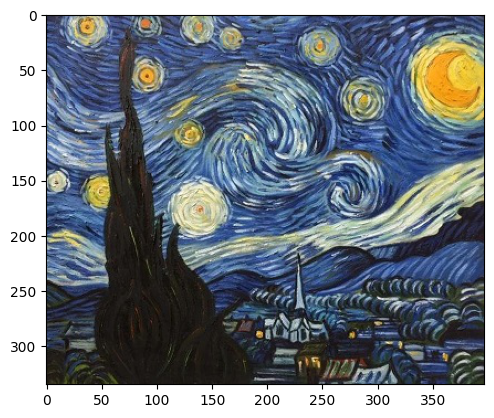

In [4]:
if MAIN:
    fname = "./w1d4_vangogh.jpg"
    img = Image.open(fname)
    print(f"Image size in pixels: {img.size[0]} x {img.size[1]} = {img.size[0] * img.size[1]}")
    plt.imshow(img)
    pass


## Build Your Own TensorDataset

The class `torch.utils.data.dataset.TensorDataset` is a convenient wrapper for passing around multiple tensors that have the same size in the first dimension. The most common example of this is in supervised learning, where you have one tensor of inputs and a second tensor with corresponding labels. Often these tensors will have different `dtype`s, so it doesn't make sense to `torch.stack` them into one big tensor, and it be cumbersome to pass them around as separate variables or as a tuple.

`TensorDataset` accepts and stores any number of tensors in the constructor along with implementing `__getitem__` so that `my_dataset[n]` returns a tuple containing element `n` from each stored `Tensor`. Similarly, `my_dataset[:5]` returns a tuple containing the first five elements from each stored `Tensor`.

### Slice Objects in Python

`slice` is a built-in type containing `start`, `stop`, and `step` fields which can be integers or `None`. Given `x=[1,2,3,4,5,6,7]`, writing `x[1:5:2]` is syntactic sugar for `x[slice(1, 5, 2)]`.


In [5]:
class TensorDataset:
    def __init__(self, *tensors: t.Tensor):
        """Validate the sizes and store the tensors in a field named `tensors`."""
        if tensors:
            # sum(tensor.shape[0] == tensors[0].shape[0] for tensor in tensors) = tensors.shape[0]
            assert all(
                tensor.shape[0] == tensors[0].shape[0] for tensor in tensors
            ), "Size mismatch between tensors"
        self.tensors = tensors

    def __getitem__(self, index: Union[int, slice]) -> Tuple[t.Tensor, ...]:
        """Return a tuple of length len(self.tensors) with the index applied to each."""
        # returns a tuple containing the first five elements from each stored Tensor.
        return tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        """Return the size in the first dimension, common to all the tensors."""
        return self.tensors[0].shape[0]


if MAIN:
    w1d4_part1_test.test_tensor_dataset(TensorDataset)

Testing with index: 0
Testing with index: slice(0, 5, 1)
Testing with index: slice(1, 5, 2)
w1d4_part1_test.test_tensor_dataset passed in 0.02s.



## Data Preprocessing

Most of the work in training a neural network is getting the data in top condition first. The relevant saying is "garbage in, garbage out".

The `preprocess_image` function do the following:

- Use `transforms.ToTensor()(img)` to obtain a tensor of shape `(channels, height, width)`.
- Remove the fourth (alpha) channel if present and just use the first three channels which are R, G, B values.
- Build a tensor of all combinations of `(x, y)` from `(0, 0)` up to `(height, width)`. Then, scale these coordinates down to the range `[-1, 1]`. These will be the inputs to your model. Without scaling them down, the training would either be very slow or not work at all.
- Build a tensor of the corresponding RGB values and scale each color to the range `[-1, 1]`. These will be the labels.
- Return the inputs and labels wrapped in a `TensorDataset`.

Execute the following cell, and make sure you understand what is happening:


In [6]:
img_t = transforms.ToTensor()(img)[:3, :, :]
labels = rearrange(img_t, "c h w -> (h w) c") * 2.0 - 1.0
print(img_t.shape, labels.shape)

torch.Size([3, 335, 397]) torch.Size([132995, 3])


In [7]:
def all_coordinates_scaled(height: int, width: int) -> t.Tensor:
    """Return a tensor of shape (height*width, 2) where each row is a (x, y) coordinate.

    The range of x and y should be from [-1, 1] in both height and width dimensions.
    """
    # [0,1,...W-1] arage -> [0,1,...W-1,0,1,...W-1] repeat -> [0,1/W,...,W-1/W] normalize
    xs = repeat(t.arange(width, dtype=t.float32), "w -> (h w)", h=height) / width
    ys = repeat(t.arange(height, dtype=t.float32), "h -> (h w)", w=width) / height
    return t.stack((xs, ys), dim=1) * 2.0 - 1.0


def preprocess_image(img: Image.Image) -> TensorDataset:
    """Convert an image into a supervised learning problem predicting (R, G, B) given (x, y).

    Return: TensorDataset wrapping input and label tensors.
    input: shape (num_pixels, 2)
    label: shape (num_pixels, 3)
    """
    # remove the 4th dimension if present
    img_t = transforms.ToTensor()(img)[:3, :, :]
    _, height, width = img_t.shape
    X = all_coordinates_scaled(height, width)
    labels = rearrange(img_t, "c h w -> (h w) c") * 2.0 - 1.0
    return TensorDataset(X, labels)



### Train-Test Split

Next, we will randomly split the data into 1. a training set that the model will use for computing gradients, 2. a validation set that will be used later for choosing hyperparameters, and 3. a held-out test set that will tell us how well the model is generalizing. For validation and test statistics to be a reliable measure of generalization, it is necessary for the training set to not overlap with the validation or test sets.

This was relatively straightforward in the era of small datasets that could be thoroughly inspected by humans, but is increasingly an issue as models are trained on massive piles of haphazardly cleaned Internet data. When reading ML papers, it's important to evaluate the potential for "leakage" between sets.

You'll see rules of thumb online about how much of your data to use for training/validation/test sets, such as a "80%/10%/10% split". In deep learning, these are generally wrong. The size of the validation and test sets only need to be big enough that sampling error doesn't introduce too much noise into the resulting estimate.

For example, ImageNet has around 1.3 million training images and only 50K validation images. The percentage (under 4%) is irrelevant and what matters is that 50K is large enough in absolute terms to achieve some standard error of the mean. Implement `train_test_split` below to split the dataset as described.

Hint: use [`torch.randperm`](https://pytorch.org/docs/stable/generated/torch.randperm.html).


In [8]:
def train_test_split(all_data: TensorDataset, train_frac=0.8, val_frac=0.01, test_frac=0.01) -> List[TensorDataset]:
    """Return [train, val, test] datasets containing the specified fraction of examples.

    If the fractions add up to less than 1, some of the data is not used.
    """
    # n = len(all_data)
    # index = t.randperm(n)
    # start = int(n*train_frac)
    # train_index = index[:start]
    # val_index = index[start:int(start+n*val_frac)]
    # start = int(start+n*val_frac)
    # test_index = index[start:int(start+n*test_frac)]
    # return TensorDataset(*all_data[train_index]), TensorDataset(*all_data[val_index]), TensorDataset(*all_data[test_index])

    "SOLUTION"
    n = len(all_data)
    perm = t.randperm(n)
    start = 0
    out = []
    for frac in [train_frac, val_frac, test_frac]:
        split_size = int(n * frac)
        idx = perm[start : start + split_size]
        out.append(TensorDataset(*all_data[idx]))
        start += split_size
    return out


if MAIN:
    all_data = preprocess_image(img)
    (train_data, val_data, test_data) = train_test_split(all_data)
    print(f"Dataset sizes: train {len(train_data)}, val {len(val_data)} test {len(test_data)}")


Dataset sizes: train 106396, val 1329 test 1329



### Visualizing the Training Data

Many times, I've made errors in the preprocessing step and not noticed because my model still trains and learns anyway, just at a lower accuracy than was possible. One way to reduce the chance of this happening is to inspect the preprocessed data carefully to see if it still makes sense.

We make a zero tensor of shape `(height, width, 3)` representing the grid of pixels, that we display with `plt.imshow`.

Just execute the following cell:


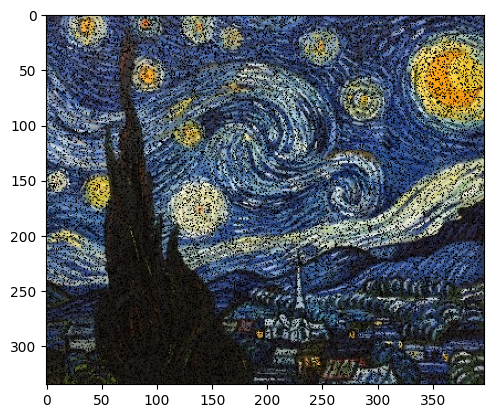

In [9]:
def to_grid(X: t.Tensor, Y: t.Tensor, width: int, height: int) -> t.Tensor:
    """Convert preprocessed data from the format used in the Dataset back to an image tensor.

    X: shape (n_pixels, dim=2)
    Y: shape (n_pixels, channel=3)

    Return: shape (height, width, channels=3)
    """
    X = ((X + 1.0) / 2.0 * t.tensor([width, height]) + 0.5).long()
    x_coords = X[:, 0]
    y_coords = X[:, 1]
    Y = (Y + 1.0) / 2.0
    grid = t.zeros((height, width, 3))
    grid[y_coords, x_coords] = Y
    return grid


if MAIN:
    width, height = img.size
    X, Y = train_data.tensors
    plt.figure()
    plt.imshow(to_grid(X, Y, width, height))


## DataLoaders

Today, our `Dataset` is small enough to fit in memory, so we could just use `torch.randperm` on our training set to fetch random batches from it.

In general, we only want to load parts of our dataset as they're needed because our dataset may be too large to fit in memory, it may take too long to preprocess the entire dataset, or we may just want the GPU to be active as much as possible instead of waiting for data to be ready.

This is where `torch.DataLoader` comes in. A `DataLoader` instance is responsible for spawning multiple worker processes which load data in parallel and communicate back to the `DataLoader`. Ideally, the `DataLoader` can prepare the next batch while the GPU is processing the current one, eliminating GPU downtime.

We'll implement our own version of this another day when we're dealing with parallelism, and just use the PyTorch implementation today. We've provided DataLoaders with `shuffle=True` for the train loader. What would happen if you didn't shuffle the training data?

<details>
<summary>Answer - Shuffling Training Data</summary>

If our training data was sorted and we didn't shuffle it at least once, then the learning process could oscillate instead of converging. Suppose that the top half of the image was mostly blue sky and the bottom half was mostly green grass. The model would get gradients that first suggest "everything is mostly blue" and later "everything is mostly green" successively. In this case, we already used `randperm` above so our training data has been shuffled regardless.

In practice, SGD is relatively insensitive to whether you shuffle on every epoch, just once, or even sample each minibatch with replacement from the full dataset. For some theory behind this, see [this paper](https://arxiv.org/pdf/2106.06880.pdf).

</details>


In [10]:
if MAIN:
    train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=256)
    test_loader = DataLoader(test_data, batch_size=256)


Implement the `train_one_epoch` function below.

- Use the `to()` method of a `Tensor` to send the data to the device indicated by the global variable `device`.
- You can convert a one-element tensor to a regular Python number using the `item` method.

<details>

<summary>It's not working and I'm confused!</summary>

- Did you remember to call `optimizer.zero_grad()` before each forward pass?
- Does `model.parameters()` return what you expect?
- Are you calling `backward()` on the mean loss over the batch items? Note that if you don't use the mean, the magnitude of the gradients scales up linearly with the batch size, which is not what you want.

</details>


In [35]:
def train_one_epoch(model: ImageMemorizer, dataloader: DataLoader) -> float:
    """Show each example in the dataloader to the model once.

    Use `torch.optim.Adam` for the optimizer (you'll build your own Adam optimizer later today).
    Use `F.l1_loss(prediction, actual)` for the loss function. This just puts less weight on very bright or dark pixels, which seems to produce nicer images.

    Return: the average loss per example seen, i.e. sum of losses of each batch weighted by the size of the batch, divided by the total number of examples seen
    """
    model.to(device)
    model.train()
    optimizer = t.optim.Adam(model.parameters())
    sum_loss = 0.0
    n_elem = 0
    for X,y in dataloader:
        X = X.to(device)
        y_preds = model(X)
        optimizer.zero_grad()
        loss = F.l1_loss(y_preds, y.to(device)) # returns a tensor
        loss.backward() # TO DO : So take mean or not mean i am confused
        optimizer.step()
        sum_loss += loss.item() * len(X) # actually also works with just loss
        n_elem += len(X)
    return sum_loss /n_elem


if MAIN:
    w1d4_part1_test.test_train(train_one_epoch)


def evaluate(model: ImageMemorizer, dataloader: DataLoader) -> float:
    """Return the total L1 loss over the provided data divided by the number of examples."""
    model.to(device)
    model.eval()  # Does nothing on this particular model, but good practice to have it
    with t.inference_mode():
        sum_loss = 0.0
        n_elems = 0
        for X, y in dataloader:
            sum_loss += F.l1_loss(model(X.to(device)), y.to(device)).item() * len(X)
            n_elems += len(X)
        return sum_loss / n_elems

if MAIN:
    w1d4_part1_test.test_evaluate(evaluate)

  0%|          | 0/4 [00:00<?, ?it/s]

w1d4_part1_test.test_train passed in 0.09s.


  0%|          | 0/4 [00:00<?, ?it/s]

w1d4_part1_test.test_evaluate passed in 0.09s.



The following cell creates a model with 400 neurons in each hidden layer and trains it for an epoch.

If no errors appeared, do a few more epochs and plot the training loss and validation loss over time as a function of number of epochs. Compute the validation loss using your `evaluate` function. I was able to reach a validation loss below 0.2 after 40 epochs. Your image might be easier or harder to learn.


  0%|          | 0/1 [00:00<?, ?it/s]

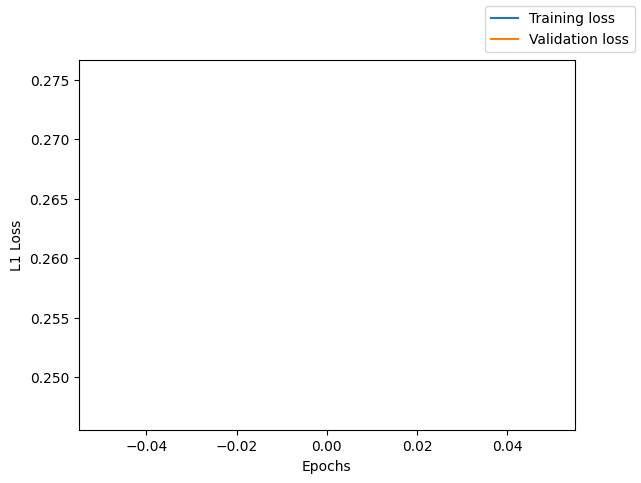

In [36]:
if MAIN:
    model = ImageMemorizer(2, 400, 3)
    train_losses = []
    val_losses = []
    
    num_epochs = 1
    bar = tqdm(range(num_epochs))
    for epoch in bar:
        train_losses.append(train_one_epoch(model, train_loader))
        val_loss = evaluate(model, val_loader)
        bar.set_description(f"val loss: {val_loss:.3f}")
        bar.refresh()
        val_losses.append(val_loss)

    fig, ax = plt.subplots()
    ax.plot(train_losses, label="Training loss")
    ax.plot(val_losses, label="Validation loss")
    ax.set(xlabel="Epochs", ylabel="L1 Loss")
    fig.legend()



Finally, execute this cell to display the image your network has memorized:


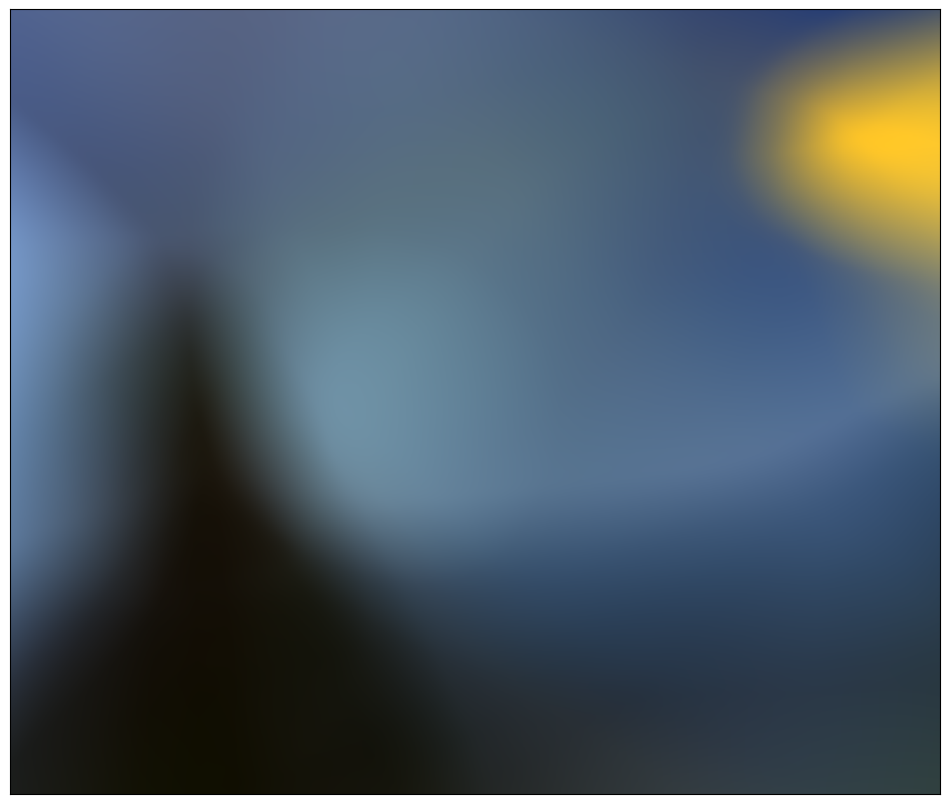

In [37]:
if MAIN:
    X = all_coordinates_scaled(height, width)
    with t.inference_mode():
        Y = model(X.to(device)).cpu()
    grid = to_grid(X, Y, width, height)
    grid.clip_(0, 1)
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(grid)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # ax.set_position([0, 0, 1, 1])
    # fig.savefig("w1d4_vangogh_solution.jpg")


Share your image with your friends if you like it! Here's the one my network learned:

![Alt text](https://github.com/EffiSciencesResearch/ML4G/blob/main/mlab/w1d4_vangogh_solution.jpg?raw=true "a title")


## Visualising Optimization With Rosenbrock's Banana

"Rosenbrock's Banana" is a (relatively) famous function that has a simple equation but is challenging to optimize because of the shape of the loss landscape.

Use `plot_rosenbrock` to plot the log of the function. Where is the minimum?

<details>

<summary>Solution</summary>

The first term is minimized when $x=a$ and the second term is minimized when $y = x^2 = a^2$. For $a=1$, it's $(1, 1)$. Looking at the plot, this seems reasonable.

</details>

<details>

<summary>How do I generate the $x$ and $y$ values for my contour plot?</summary>

For each dimension, use `torch.linspace` to generate evenly spaced values, then `einops.repeat`.

</details>


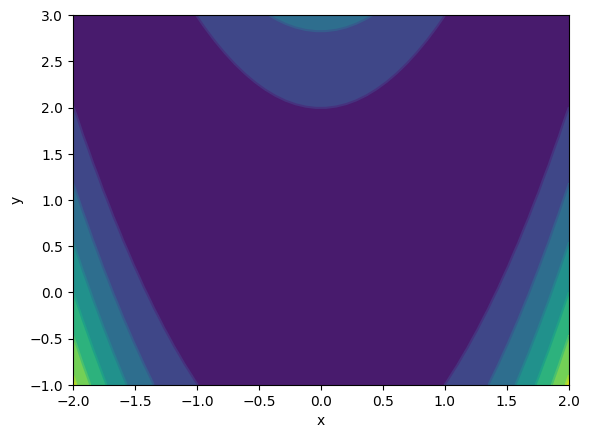

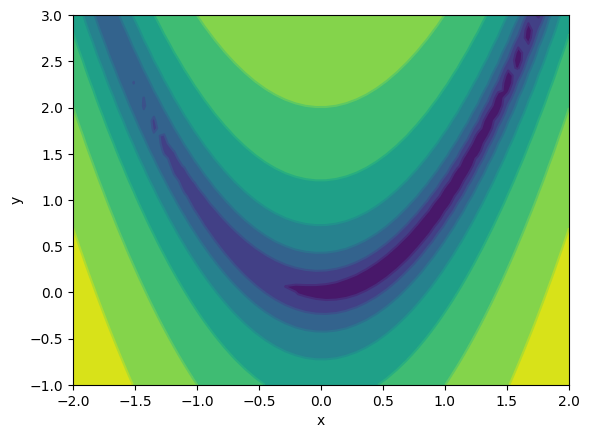

In [38]:
def rosenbrocks_banana(x: t.Tensor, y: t.Tensor, a=1, b=100) -> t.Tensor:
    return (a - x) ** 2 + b * (y - x**2) ** 2 + 1


def plot_rosenbrock(xmin=-2, xmax=2, ymin=-1, ymax=3, n_points=50, log_scale=False) -> matplotlib.figure.Figure:
    """Plot the rosenbrocks_banana function over the specified domain.

    If log_scale is True, take the logarithm of the output before plotting.
    """
    "SOLUTION"
    fig, ax = plt.subplots()
    x = t.linspace(xmin, xmax, n_points)
    y = t.linspace(ymin, ymax, n_points)
    xx = repeat(x, "x -> y x", y=n_points)
    yy = repeat(y, "y -> y x", x=n_points)
    zs = rosenbrocks_banana(xx, yy)
    contour = ax.contourf(x, y, t.log(zs) if log_scale else zs)
    ax.contour(contour)
    ax.set(xlabel="x", ylabel="y")
    return fig

if MAIN:
    plot_rosenbrock()
    fig = plot_rosenbrock(log_scale=True)


# Optimize The Banana

Implement the `opt_banana` function using `torch.optim.SGD`. Starting from `(-1.5, 2.5)`, run your function and add the resulting trajectory of `(x, y)` pairs to your contour plot. Did it find the minimum? Play with the learning rate and momentum a bit and see how close you can get within 100 iterations.

<details>

<summary>I'm not sure if my `opt_banana` is implemented properly.</summary>

With a learning rate of `0.001` and momentum of `0.98`, my SGD was able to reach `[ 1.0234299 ,  1.198282 ]` after 100 iterations.

</details>

<details>

<summary>I'm getting "Can't call numpy() on Tensor that requires grad" and I don't know why!</summary>

This is a protective mechanism built into PyTorch. The idea is that once you convert your `Tensor` to NumPy, PyTorch can no longer track gradients, but you might not understand this and expect backprop to work on NumPy arrays.

All you need to do to convince PyTorch you're a responsible adult is to call `detach()` on the tensor first, which returns a view that does not require grad and isn't part of the computation graph.

</details>


[1.0234317 1.1982855]


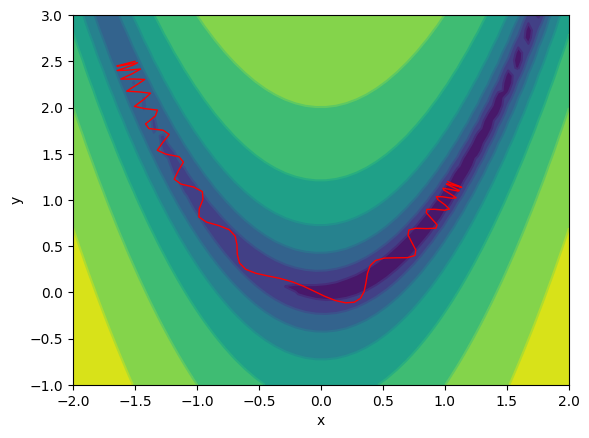

In [49]:
def opt_banana(xy: t.Tensor, n_iters: int, lr=0.001, momentum=0.98):
    """Optimize the banana starting from the specified point.

    xy: shape (2,). The (x, y) starting point.
    n_iters: number of steps.

    Return: (n_iters, 2). The (x,y) BEFORE each step. So out[0] is the starting point.
    """
    assert xy.requires_grad
    out = xy.new_zeros((n_iters, 2))
    opt = t.optim.SGD([xy], lr, momentum)
    for n in range(n_iters):
      out[n] = xy.detach()
      opt.zero_grad()
      rosenbrocks_banana(xy[0], xy[1]).backward()
      opt.step() 
    return out


if MAIN:
    xy = t.tensor([-1.5, 2.5], requires_grad=True)
    xys = opt_banana(xy, n_iters=100).numpy()
    print(xys[-1])
    fig = plot_rosenbrock(log_scale=True)
    fig.axes[0].plot(xys[:, 0], xys[:, 1], color="r", linewidth=1)



## Build Your Own Optimizers

Now let's build our own drop-in replacement for these three classes from `torch.optim`. The documentation pages for these algorithms have pseudocode you can use to implement your step method.

### Gotcha: In-Place Operations

Be careful with expressions like `x = x + y` and `x += y`. They are NOT equivalent in Python.

- The first one allocates a new `Tensor` of the appropriate size and adds `x` and `y` to it, then rebinds `x` to point to the new variable. The original `x` is not modified.
- The second one modifies the storage referred to by `x` to contain the sum of `x` and `y` - it is an "in-place" operation.
  - Another way to write the in-place operation is `x.add_(y)` (the trailing underscore indicates an in-place operation).
  - A third way to write the in-place operation is `torch.add(x, y, out=x)`.
- This is rather subtle, so make sure you are clear on the difference. This isn't specific to PyTorch; the built-in Python `list` follows similar behavior: `x = x + y` allocates a new list, while `x += y` is equivalent to `x.extend(y)`.
- In general, the first version calls the method `x.__add__(y)` while the second calls `x.__iadd__(y)`, and these two methods can have arbitrary semantics.

The tricky thing that happens here is that both the optimizer and the `Module` in your model have a reference to the same `Parameter` instance. Do we want to use in-place operations in our optimizer?

<details>

<summary>Solution - In-place Operations</summary>

You MUST use in-place operations in your optimizer because we want the model to see the change to the Parameter's storage on the next forward pass. If your optimizer allocates a new tensor, the model won't know anything about the new tensor and will continue to use the old, unmodified version.

</details>

### More Tips

- The provided `params` might be a generator, in which case you can only iterate over it once before the generator is exhausted. Copy it into a `list` to be able to iterate over it repeatedly.
- Your step function shouldn't modify the gradients. Use the `with torch.inference_mode():` context for this. Fun fact: you can instead use `@torch.inference_mode()` (note the preceding `@`) as a method decorator to do the same thing.
- If you create any new tensors, they should be on the same device as the corresponding parameter. Use `torch.zeros_like()` or similar for this.
- Be careful not to mix up `Parameter` and `Tensor` types in this step.
- The actual PyTorch implementations have an additional feature called parameter groups where you can specify different hyperparameters for each group of parameters. You can ignore this for today.

Tip: It is possible to not use if conditions in sgd and Adam. This simplifies the code.

### SGD


In [54]:
class SGD:
    def __init__(self, params: Iterable[t.nn.parameter.Parameter], lr: float, momentum: float, weight_decay: float):
        """Implements SGD with momentum.

        Like the PyTorch version, but assume nesterov=False, maximize=False, and dampening=0
            https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD

        """
        self.params = list(params)
        self.lr = lr
        self.mu = momentum
        self.wd = weight_decay
        self.b = [t.zeros_like(p) for p in self.params]

    def zero_grad(self) -> None:
        for param in self.params:
            param.grad = None
    
    def step(self) -> None:
        with t.inference_mode():
            for i, p in enumerate(self.params):
                g = p.grad + self.wd*p
                if self.mu:
                    self.b[i] = self.mu*self.b[i] + g
                    g = self.b[i]
                p -= self.lr*g
                      
if MAIN:
    w1d4_part1_test.test_sgd(SGD)


Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'weight_decay': 0.0}

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'weight_decay': 0.0}

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'weight_decay': 0.0}

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'weight_decay': 0.05}

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'weight_decay': 0.05}
w1d4_part1_test.test_sgd passed in 0.13s.


In [ ]:
class SGD:
    def __init__(
        self,
        params: Iterable[t.nn.parameter.Parameter],
        lr: float,
        momentum: float,
        weight_decay: float,
    ):
        """Implements SGD with momentum.

        Like the PyTorch version, but assume nesterov=False, maximize=False, and dampening=0
            https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD

        """
        "SOLUTION"
        self.params = list(params)
        self.lr = lr
        self.wd = weight_decay
        self.mu = momentum
        self.b: List[Optional[t.Tensor]] = [None for _ in self.params]

    def zero_grad(self) -> None:
        "SOLUTION"
        for p in self.params:
            p.grad = None

    def step(self) -> None:
        "SOLUTION"
        with t.inference_mode():
            for i, p in enumerate(self.params):
                g = p.grad + self.wd * p
                if self.mu:
                    b = self.b[i]
                    if b is not None:
                        self.b[i] = self.mu * b + g
                    else:
                        self.b[i] = g
                    g = self.b[i]  # type: ignore
                p -= self.lr * g  # type: ignore




### Adam


In [60]:
class Adam:
    def __init__(
        self,
        params: Iterable[t.nn.parameter.Parameter],
        lr: float = 0.001,
        betas: Tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-08,
        weight_decay: float = 0.0,
    ):
        """Implements Adam.

        Like the PyTorch version, but assumes amsgrad=False and maximize=False
            https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam
        """
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.wd = weight_decay

        self.m = [t.zeros_like(p) for p in self.params]
        self.v = [t.zeros_like(p) for p in self.params]
        self.t = 0

    def zero_grad(self) -> None:
        for p in self.params:
            p.grad = None

    def step(self) -> None:
        self.t += 1
        with t.inference_mode():
            for i,p in enumerate(self.params):
                assert p.grad is not None
                g = p.grad + self.wd*p
                self.m[i] = self.betas[0]*self.m[i] + (1-self.betas[0])*g
                self.v[i] = self.betas[1]*self.v[i] + (1-self.betas[1])*g*g
                m = self.m[i] / (1-self.betas[0]**self.t)
                v = self.v[i] / (1-self.betas[1]**self.t)
                p -= self.lr*m/(v.sqrt() + self.eps)


if MAIN:
    w1d4_part1_test.test_adam(Adam)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
w1d4_part1_test.test_adam passed in 0.26s.
